# Formação de baseline com modelos estatísticos

## Introdução
Utiliza o Scikit Learn para formação de baseline com algoritmos estatísticos afim de servir como parâmetro de comparação com outros modelos.

O dataset utilizado foi gerado a partir do notebook "Analise de boletins de jurisprudencia.ipynb" na pasta "eda" e contém os seguintes atributos:

|Campo             |Descrição                                                                                           |
|------------------|----------------------------------------------------------------------------------------------------|
|arquivo           |Arquivo de onde foi extraído o dado                                                                 |
|ano_mes           |Ano e mês   obtidos a partir do campo arquivo no formato AAAA-MM                                    |
|sumario           |Sumário do   boletim                                                                                |
|ementa            |Ementa da   decisão proferida                                                                       |
|informacoes       |Informações   do processo                                                                           |
|área_tematica     |Assunto da   decisão (variável alvo)                                                                |
|decisao_tipo      |Tipo da   decisão proferida                                                                         |
|decisao_numero    |Número da   decisão proferida                                                                       |
|decisao_ano       |Ano da   decisão proferida                                                                          |
|assunto_agrupado  |Resultado do agrupamento da coluna area_tematica durante processo de análise. (variável dependente) |

Cria modelos usando bag of words e TfIdf do sklearn

Criado po Antonio Filho em 04/10/2020 e atualizado em 28/10/2020

## Importação de bibliotecas

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
sys.path.insert(0, os.path.abspath('../../src'))
import nlp_utils

'''Desbalanceamento'''
from imblearn.over_sampling import SMOTE

'''Features'''
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
#from sklearn import preprocessing
#from sklearn.compose import ColumnTransformer
from nltk import FreqDist, word_tokenize

'''Classificadores'''
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Métricas/avaliação'''
from sklearn.model_selection import GridSearchCV  # Busca os melhores parâmetros para o treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, accuracy_score, \
    plot_confusion_matrix, precision_score, recall_score
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

'''Persistência'''
from joblib import dump, load

'''Plotagem'''
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

from pprint import pprint
from time import time
import logging

print(__doc__)
# Display progress logs on stdout (Ajuda a entender em que ponto está a execução. Útl para as combinações feitas pelo GridAearch)
logging.basicConfig(level=logging.INFO,format='%(asctime)s %(levelname)s %(message)s')

Plotagem


## Carregar os dados

In [2]:
caminho_dados = Path("../../data/")
df = pd.read_csv(caminho_dados/"processed/tcepi_decisoes_ate_10_2020.csv", sep=";")

In [3]:
df.head()

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade
0,Boletim de Jurisprudência TCE-PI - julho - 19....,2019-07,Responsabilidade. Desvio de finalidade. Não ex...,RECURSO DE RECONSIDERAÇÃO. TOMADA DE CONTAS. S...,(Recurso de Reconsideração. Processo – Relato...,RESPONSABILIDADE,acordao,1183,2019.0,RESPONSABILIDADE,9,0
1,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Responsabilidade. Ausência de responsabilizaçã...,RESPONSABILIDADE. CONTRATOS FIRMADOS ANTERIORE...,(Pedido de Revisão. Processo – Relator: Cons....,RESPONSABILIDADE,acordao,1129,2020.0,RESPONSABILIDADE,9,0
2,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Responsabilidade. Responsabilidade solidária d...,CONTROLE INTERNO DA PREFEITURA. SUBLOCAÇÃO DE ...,(Prestação de Contas. Processo – Relatora: Co...,RESPONSABILIDADE,acordao,1169,2020.0,RESPONSABILIDADE,9,0
3,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,Responsabilidade. Ausência de planejamento pel...,PRESTAÇÃO DE CONTAS. DESPESAS COM MULTAS E JUR...,(Prestação de Contas. Processo – Relator: Con...,RESPONSABILIDADE,acordao,433,2020.0,RESPONSABILIDADE,9,0
4,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,Responsabilidade. Não responsabilização do atu...,AUDITORIA DE OBRAS E SERVIÇOS DE ENGENHARIA. I...,(Auditoria. Processo – Relator: Conselheiro J...,RESPONSABILIDADE,acordao,506,2020.0,RESPONSABILIDADE,9,0


In [4]:
df.tail()

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade
647,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,FUNDEB. Irregularidade na utilização do precat...,IRREGULARIDADES NA APLICAÇÃO DE PRECATÓRIOS DO...,(Representação. Processo 7 – Relator: Cons. Jo...,FUNDEB,acordao,582,2020.0,OUTROS,21,21
648,Boletim de Jurisprudência TCE-PI - Janeiro - 1...,2018-01,Tributação. Isenções fiscais de ICMS sem a rea...,EMENTA. RENÚNCIA DE RECEITAS. GUERRA FISCAL. F...,(Prestação de Contas. Processo – Relator: Con...,TRIBUTACAO,acordao,3085,2017.0,OUTROS,22,22
649,Boletim de Jurisprudência TCE-PI - Junho - 18....,2018-06,Patrimônio. Inexistência de registros analític...,PRESTAÇÃO DE CONTAS. AUSÊNCIA DE REGISTRO PATR...,(Prestação de Contas. Processo – Relator: Con...,PATRIMONIO,acordao,840,2018.0,OUTROS,23,23
650,Boletim de Jurisprudência TCE-PI - Outubro - 1...,2019-10,Representação. Prestação de contas em atraso c...,REPRESENTAÇÃO. PEDIDO DE BLOQUEIO DE CONTAS. P...,(Prestação de Contas. Processo 9 – Relator: Co...,REPRESENTACAO,acordao,1584,2019.0,OUTROS,24,24
651,Boletim de Jurisprudência TCE-PI - agosto 2020...,2020-08,Pagamento. Pagamentos em espécie superior ao l...,TOMADA DE CONTAS ESPECIAL. PAGAMENTOS EM ESPÉC...,(Tomada de Contas. Processo – Relator: Cons. ...,PAGAMENTO,acordao,736,2020.0,OUTROS,25,25


In [5]:
df.shape

(652, 12)

In [6]:
# Distribuição da variável dependente
pd.DataFrame(df.assunto_agrupado.value_counts())\
        .assign(percentual=df.assunto_agrupado.value_counts(normalize=True))\
        .rename(columns={'assunto_agrupado': 'qtde'})

,qtde,percentual
LICITACAO,122,0.187117
PESSOAL,118,0.180982
OUTROS,106,0.162577
DESPESA,65,0.099693
PROCESSUAL,62,0.095092
PRESTACAO DE CONTAS,46,0.070552
CONTRATO,43,0.065951
PREVIDENCIA,35,0.053681
AGENTE POLITICO,31,0.047546
RESPONSABILIDADE,24,0.036810


## Criar dataset para teste

In [7]:
def create_test_dataset(df: pd.DataFrame, percent: int) -> pd.DataFrame:
    df_freq = pd.DataFrame(df.assunto_agrupado.value_counts())\
        .assign(percentual=df.assunto_agrupado.value_counts(normalize=True))\
        .rename(columns={'assunto_agrupado': 'qtde'})

    df_test = df.copy()[0:0]
    for index, row in df_freq.iterrows(): 
        df_test = df_test.append(df[df.assunto_agrupado==index].sample(int((row["qtde"])*(percent/100))))
    
    return df_test

In [8]:
df_test = create_test_dataset(df, 15)
df_test

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade
438,Boletim de Jurisprudência TCE-PI - junho - 19....,2019-06,Licitação. Irregularidade no processo licitató...,DENÚNCIA. IRREGULARIDADE EM PROCEDIMENTO LICIT...,(Denúncia. Processo – Relator: Cons. Joaquim ...,LICITACAO,acordao,959,2019.0,LICITACAO,1,8
430,Boletim de Jurisprudência TCE-PI - Outubro - 1...,2018-10,Licitação. Exigência integral das funcionalida...,AGRAVO REGIMENTAL. PREGÃO ELETRÔNICO. SOFTWARE...,(Agravo Regimental. Processo – Relator: Cons....,LICITACAO,acordao,1589,2018.0,LICITACAO,1,8
466,Boletim de Jurisprudência TCE-PI - Agosto-Deze...,2017-12,Licitação. Contratação de empresa em que figur...,EMENTA. LICITAÇÃO. CONTRATAÇÃO DE EMPRESA EM Q...,(Recurso de Reconsideração. Processo 7 – Relat...,LICITACAO,acordao,2757,2017.0,LICITACAO,1,8
496,Boletim de Jurisprudência TCE-PI - julho 2020 ...,2020-07,Licitação. Ausência de planejamento. Necessida...,LICITAÇÃO. IRREGULARIDADES.\n1) A ausência ou ...,(Auditoria. Processo – Relator: Cons. Subst. ...,LICITACAO,acordao,1052,2020.0,LICITACAO,1,8
522,Boletim de Jurisprudência TCE-PI -MARÇO 2020.docx,2020-03,Licitação. Publicação resumida fora do prazo d...,LICITAÇÃO. PESSOAL. CONTRATO. SERVIÇO PRESTADO...,(Prestação de Contas. Processo – Relator: Con...,LICITACAO,acordao,273,2020.0,LICITACAO,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...
44,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Agente Político. Em regra é vedada a redução d...,CÂMARA MUNICIPAL. SUBSÍDIO. VEREADORES.\nÉ ved...,(Prestação de Contas. Processo – Relator: Con...,AGENTE POLITICO,acordao,1309,2020.0,AGENTE POLITICO,8,1
43,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Agente Político. Publicação fora do prazo esta...,"DESPESA. Diferença de 0,09% entre o índice da ...",(Prestação de Contas. Processo – Relator: Con...,AGENTE POLITICO,acordao,1583,2020.0,AGENTE POLITICO,8,1
16,Boletim de Jurisprudência TCE-PI - Março - 19....,2019-03,Responsabilidade. Ausência de fiscalização. Co...,TOMADA DE CONTAS ESPECIAL. OCORRÊNCIA DE FALHA...,(Tomada de Contas Especial. Processo 7 – Relat...,RESPONSABILIDADE,acordao,306,2019.0,RESPONSABILIDADE,9,0
15,Boletim de Jurisprudência TCE-PI - Março - 19....,2019-03,Responsabilidade. Responsabilidade do Chefe do...,PEDIDO DE REVISÃO. AUSÊNCIA DE PARCELAMENTO DA...,(Recurso. Processo – Relator Cons. Joaquim Ke...,RESPONSABILIDADE,acordao,401,2019.0,RESPONSABILIDADE,9,0


In [9]:
# Distribuição da variável dependente no dataset de teste
df_comp = pd.DataFrame(df.assunto_agrupado.value_counts())\
        .assign(percentual_total=df.assunto_agrupado.value_counts(normalize=True)*100)\
        .assign(qtde_teste=df_test.assunto_agrupado.value_counts())\
        .assign(percentual_teste=df_test.assunto_agrupado.value_counts(normalize=True)*100)\
        .rename(columns={'assunto_agrupado': 'qtde_total'})
df_comp['percentual_dif'] = df_comp['percentual_teste']-df_comp['percentual_total']
df_comp

,qtde_total,percentual_total,qtde_teste,percentual_teste,percentual_dif
LICITACAO,122,18.711656,18,19.565217,0.853561
PESSOAL,118,18.098160,17,18.478261,0.380101
OUTROS,106,16.257669,15,16.304348,0.046679
DESPESA,65,9.969325,9,9.782609,-0.186716
PROCESSUAL,62,9.509202,9,9.782609,0.273406
PRESTACAO DE CONTAS,46,7.055215,6,6.521739,-0.533476
CONTRATO,43,6.595092,6,6.521739,-0.073353
PREVIDENCIA,35,5.368098,5,5.434783,0.066684
AGENTE POLITICO,31,4.754601,4,4.347826,-0.406775
RESPONSABILIDADE,24,3.680982,3,3.260870,-0.420112


### Removar do dataset geral os registros inseridos no dataset de teste

In [10]:
df_model = df[df.index.isin(df_test.index.tolist()) == False]
df_model

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade
0,Boletim de Jurisprudência TCE-PI - julho - 19....,2019-07,Responsabilidade. Desvio de finalidade. Não ex...,RECURSO DE RECONSIDERAÇÃO. TOMADA DE CONTAS. S...,(Recurso de Reconsideração. Processo – Relato...,RESPONSABILIDADE,acordao,1183,2019.0,RESPONSABILIDADE,9,0
1,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Responsabilidade. Ausência de responsabilizaçã...,RESPONSABILIDADE. CONTRATOS FIRMADOS ANTERIORE...,(Pedido de Revisão. Processo – Relator: Cons....,RESPONSABILIDADE,acordao,1129,2020.0,RESPONSABILIDADE,9,0
2,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Responsabilidade. Responsabilidade solidária d...,CONTROLE INTERNO DA PREFEITURA. SUBLOCAÇÃO DE ...,(Prestação de Contas. Processo – Relatora: Co...,RESPONSABILIDADE,acordao,1169,2020.0,RESPONSABILIDADE,9,0
3,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,Responsabilidade. Ausência de planejamento pel...,PRESTAÇÃO DE CONTAS. DESPESAS COM MULTAS E JUR...,(Prestação de Contas. Processo – Relator: Con...,RESPONSABILIDADE,acordao,433,2020.0,RESPONSABILIDADE,9,0
4,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,Responsabilidade. Não responsabilização do atu...,AUDITORIA DE OBRAS E SERVIÇOS DE ENGENHARIA. I...,(Auditoria. Processo – Relator: Conselheiro J...,RESPONSABILIDADE,acordao,506,2020.0,RESPONSABILIDADE,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
647,Boletim de Jurisprudência TCE-PI - junho 2020....,2020-06,FUNDEB. Irregularidade na utilização do precat...,IRREGULARIDADES NA APLICAÇÃO DE PRECATÓRIOS DO...,(Representação. Processo 7 – Relator: Cons. Jo...,FUNDEB,acordao,582,2020.0,OUTROS,21,21
648,Boletim de Jurisprudência TCE-PI - Janeiro - 1...,2018-01,Tributação. Isenções fiscais de ICMS sem a rea...,EMENTA. RENÚNCIA DE RECEITAS. GUERRA FISCAL. F...,(Prestação de Contas. Processo – Relator: Con...,TRIBUTACAO,acordao,3085,2017.0,OUTROS,22,22
649,Boletim de Jurisprudência TCE-PI - Junho - 18....,2018-06,Patrimônio. Inexistência de registros analític...,PRESTAÇÃO DE CONTAS. AUSÊNCIA DE REGISTRO PATR...,(Prestação de Contas. Processo – Relator: Con...,PATRIMONIO,acordao,840,2018.0,OUTROS,23,23
650,Boletim de Jurisprudência TCE-PI - Outubro - 1...,2019-10,Representação. Prestação de contas em atraso c...,REPRESENTAÇÃO. PEDIDO DE BLOQUEIO DE CONTAS. P...,(Prestação de Contas. Processo 9 – Relator: Co...,REPRESENTACAO,acordao,1584,2019.0,OUTROS,24,24


### Salvar datasetes para teste e para modelagem (treino e validação)

In [11]:
# Dataset de teste
df_test.to_csv(Path("../../data/processed/tcepi_decisoes_test.csv"), index=False, sep=';')

# Dataset para uso na modelagem
df_model.to_csv(Path("../../data/processed/tcepi_decisoes_model.csv"), index=False, sep=';')

In [12]:
del df

## Criar modelo para predição de classes

In [13]:
caminho_dados = Path("../../data/")
df_model = pd.read_csv(caminho_dados/"processed/tcepi_decisoes_model.csv", sep=";")
df_test = pd.read_csv(caminho_dados/"processed/tcepi_decisoes_test.csv", sep=";")

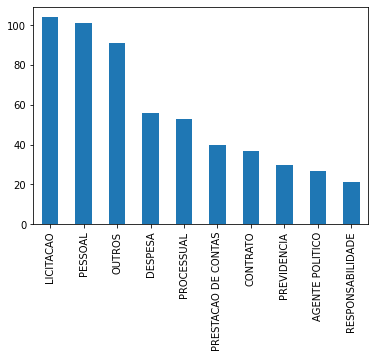

In [14]:
df_model.assunto_agrupado.value_counts().plot(kind='bar')

In [15]:
# Usar comando stratify para garantir que o percentual das classe  permaneça nos 2 conjuntos
X_train, X_test, y_train, y_test = \
    train_test_split(df_model.ementa, df_model.assunto_agrupado, test_size=0.2, shuffle=True, \
                     stratify=df_model.assunto_agrupado, random_state=42)

In [16]:
X_train[:10]

26     RECURSO DE RECONSIDERAÇÃO. PRESTAÇÃO DE CONTAS...
129    REPRESENTAÇÃO. NÃO OBSERVÂNCIA AOS PRINCIPIOS ...
12     LICITAÇÕES E CONTRATOS. FRAGMENTAÇÃO DE DESPES...
97     CONTRATO. EMPRESA PROIBIDA DE CONTRATAR COM O ...
440    TOMADA DE CONTAS ESPECIAL. IMPLANTAÇÃO DE ESTR...
450    CONTAS DA CÂMARA MUNICIPAL. IRREGULARIDADES EM...
11     PRESTAÇÃO DE CONTAS. NÃO REMANESCÊNCIA DE OCOR...
424    ANÁLISE DE PRESTAÇÃO DE CONTAS. IRREGULARIDADE...
237    GASTO COM PROFISSIONAIS DO MAGISTÉRIO/FUNDEB I...
171    EMENTA: CONTROLE DE CONSTITUCIONALIDADE. PROJE...
Name: ementa, dtype: object

In [17]:
print('TREINO : ',y_train.shape,'\n', y_train.value_counts(normalize=True),'\n')
print('TESTE  : ',y_test.shape,'\n', y_test.value_counts(normalize=True))

TREINO :  (448,) 
 LICITACAO              0.185268
PESSOAL                0.180804
OUTROS                 0.162946
DESPESA                0.100446
PROCESSUAL             0.093750
PRESTACAO DE CONTAS    0.071429
CONTRATO               0.066964
PREVIDENCIA            0.053571
AGENTE POLITICO        0.046875
RESPONSABILIDADE       0.037946
Name: assunto_agrupado, dtype: float64 

TESTE  :  (112,) 
 LICITACAO              0.187500
PESSOAL                0.178571
OUTROS                 0.160714
PROCESSUAL             0.098214
DESPESA                0.098214
PRESTACAO DE CONTAS    0.071429
CONTRATO               0.062500
PREVIDENCIA            0.053571
AGENTE POLITICO        0.053571
RESPONSABILIDADE       0.035714
Name: assunto_agrupado, dtype: float64


In [18]:
text_train = list(X_train)
text_test = list(X_test)
text_train[:5]

['RECURSO DE RECONSIDERAÇÃO. PRESTAÇÃO DE CONTAS DA CÂMARA MUNICIPAL DE SANTA FILOMENA. EXERCÍCIO 2015. PROVIMENTO PARCIAL. ALTERAÇÃO DO JULGAMENTO PARA REGULARIDADE COM RESSALVAS. MANUTENÇÃO DA MULTA. NOMEAÇÃO DE SERVIDORA ESTABILIZADA PELO ART. 19 DO ADCT PARA O CARGO DE CONTROLADORA DA CÂMARA MUNICIPAL. VARIAÇÃO DO SUBSÍDIO DOS VEREADORES ACIMA DOS ÍNDICES INFLACIONÁRIOS. VÍCIO NA NORMA LEGAL. ATENDIMENTO AOS LIMITES CONSTITUCIONAIS. \nCaso concreto em que a Servidora fora nomeada para o cargo de Controladora da Câmara Municipal em desacordo com a Emenda Constitucional nº 38, de 13/12/2012. O posicionamento pacífico no STF é no sentido de que o instituto da Estabilidade positivado no art. 19 do ADCT (Ato das Disposições Constitucionais Transitórias) não se confunde com a Efetividade proveniente da investidura em cargo público através de prévia aprovação em concurso público;\nA finalidade da Emenda Constitucional nº 38, de 13/12/2012 é permitir que o Servidor atue de forma independen

In [19]:
target_train = list(y_train)
target_test = list(y_test)
print(target_test[:5])

['RESPONSABILIDADE', 'OUTROS', 'PROCESSUAL', 'DESPESA', 'DESPESA']


### Normalização

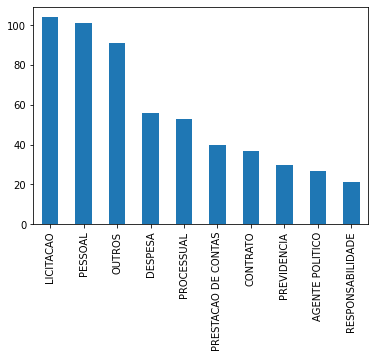

In [20]:
# Verificar se o agrupamento de assuntos está correto
df_model.assunto_agrupado.value_counts().plot(kind='bar')

In [21]:
# Fonte: https://github.com/netoferraz/o-eu-analitico/blob/master/_notebooks/2020-07-26-gov-data-product-p3.ipynb
def make_word_cloud(series: pd.Series, **kwargs):
    stopwords = kwargs.get('stopwords')
    corpus_normativos = " ".join(series)
    tokenize_corpus = word_tokenize(corpus_normativos)
    if stopwords:
        print(len(stopwords))
        wordcloud = WordCloud(width=1024, height=768, stopwords=stopwords, margin=0).generate(corpus_normativos)
    else:
        wordcloud = WordCloud(width=1024, height=768, margin=0).generate(corpus_normativos)
    #show
    plt.figure(figsize=[15, 9])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud

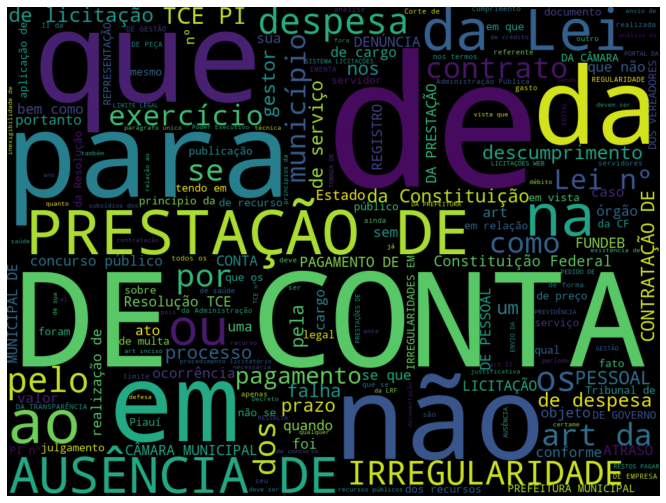

In [22]:
# Word cloud antes de normalização
make_word_cloud(df_model.ementa)

In [23]:
def frequency_plot(series: pd.Series, **kwargs):
    stopwords = kwargs.get('stopwords')
    corpus_normativos = " ".join(series)
    tokenize_corpus = word_tokenize(corpus_normativos)
    if stopwords:
        tokenize_corpus = [w for w in tokenize_corpus if w not in stopwords]
    plt.figure(figsize=(10,5))
    fd = FreqDist(tokenize_corpus)
    fd.plot(30,title = "Palavras x Frequência",cumulative=False)

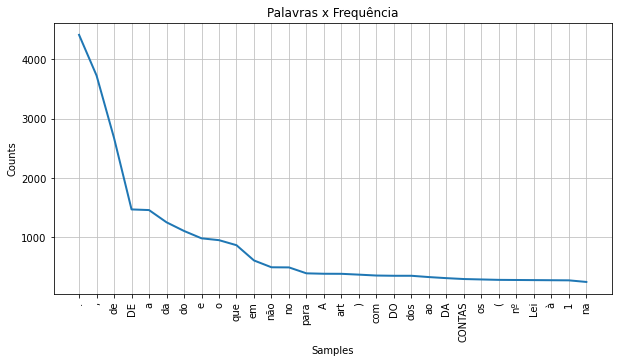

In [24]:
# Distribuição de frequência de palavras antes da normalização
frequency_plot(df_model.ementa)

In [25]:
#nlp_utils.pre_processing_pipeline(df.ementa)
df_model['ementa_limpa'] = df_model.ementa.apply(lambda x: nlp_utils.pre_processing_pipeline(x))
df_model.head(2)

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade,ementa_limpa
0,Boletim de Jurisprudência TCE-PI - julho - 19....,2019-07,Responsabilidade. Desvio de finalidade. Não ex...,RECURSO DE RECONSIDERAÇÃO. TOMADA DE CONTAS. S...,(Recurso de Reconsideração. Processo – Relato...,RESPONSABILIDADE,acordao,1183,2019.0,RESPONSABILIDADE,9,0,recurso reconsideracao tomada contas sesapi mu...
1,Boletim de Jurisprudência TCE-PI - Setembro 20...,2020-09,Responsabilidade. Ausência de responsabilizaçã...,RESPONSABILIDADE. CONTRATOS FIRMADOS ANTERIORE...,(Pedido de Revisão. Processo – Relator: Cons....,RESPONSABILIDADE,acordao,1129,2020.0,RESPONSABILIDADE,9,0,responsabilidade contratos firmados anteriores...


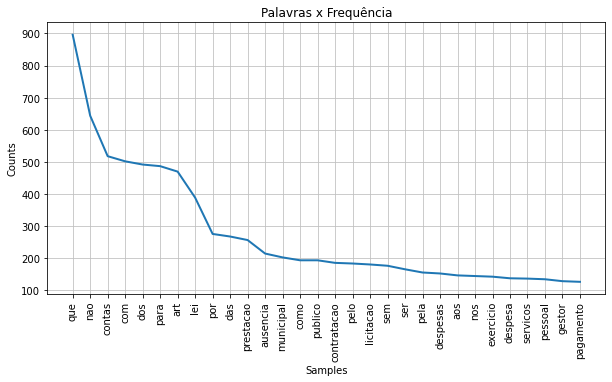

In [26]:
frequency_plot(df_model.ementa_limpa)

204


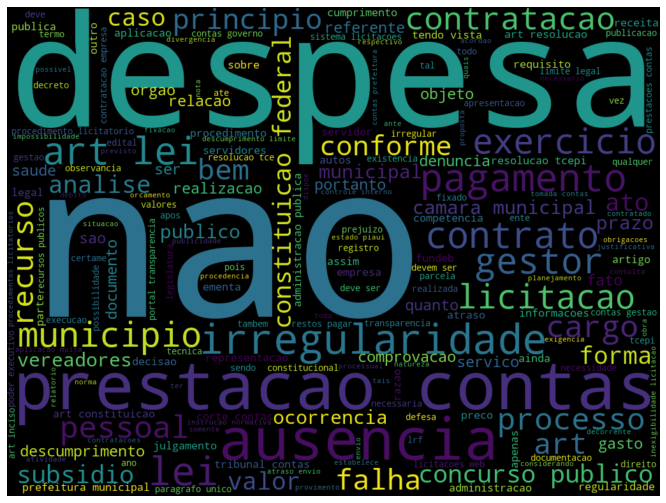

In [27]:
#remoção de stop words
from nltk.corpus import stopwords
stopwords_pt = stopwords.words('portuguese')
make_word_cloud(df_model.ementa_limpa, stopwords=stopwords_pt)

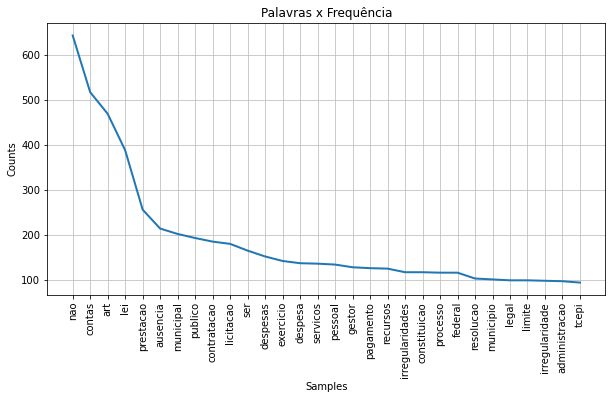

In [28]:
frequency_plot(df_model.ementa_limpa, stopwords=stopwords_pt)

In [29]:
df_test['ementa_limpa'] = df_test.ementa.apply(lambda x: nlp_utils.pre_processing_pipeline(x))
df_test.head(2)

,arquivo,ano_mes,sumario,ementa,informacoes,area_tematica,decisao_tipo,decisao_numero,decisao_ano,assunto_agrupado,rank,prioridade,ementa_limpa
0,Boletim de Jurisprudência TCE-PI - junho - 19....,2019-06,Licitação. Irregularidade no processo licitató...,DENÚNCIA. IRREGULARIDADE EM PROCEDIMENTO LICIT...,(Denúncia. Processo – Relator: Cons. Joaquim ...,LICITACAO,acordao,959,2019.0,LICITACAO,1,8,denuncia irregularidade procedimento licitator...
1,Boletim de Jurisprudência TCE-PI - Outubro - 1...,2018-10,Licitação. Exigência integral das funcionalida...,AGRAVO REGIMENTAL. PREGÃO ELETRÔNICO. SOFTWARE...,(Agravo Regimental. Processo – Relator: Cons....,LICITACAO,acordao,1589,2018.0,LICITACAO,1,8,agravo regimental pregao eletronico software r...


### Teste de algoritmos com parâmetros default

In [105]:
def score_df(model_name, y_test, y_pred, average='weighted'):
    model_name_list, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []

    model_name_list.append(model_name)
    ac_score_list.append(accuracy_score(y_test, y_pred))
    p_score_list.append(precision_score(y_test, y_pred, average=average))
    r_score_list.append(recall_score(y_test, y_pred, average=average))
    f1_score_list.append(f1_score(y_test, y_pred, average=average))
    
    df = pd.DataFrame([model_name_list, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
    df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
    return df

#Function to get the scores for each model in a df
def model_score_df():   
    model_comparison_df = pd.DataFrame(columns= ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score'])
    for k,v in model_dict.items():   
        print('Model: {}...'.format(k))
        v.fit(X_train, y_train)
        y_pred = v.predict(X_test)
       
        model_comparison_df = model_comparison_df.append(score_df(k, y_test, y_pred), ignore_index=True)

    model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

In [106]:
#Preliminary model evaluation using default parameters

#Creating a dict of the models
model_dict = {'Stochastic Gradient Descent' : SGDClassifier(random_state=3)#, loss='log')
              ,'Random Forest': RandomForestClassifier(random_state=3)
              ,'Decsision Tree': DecisionTreeClassifier(random_state=3)
              ,'Naive Bayes': MultinomialNB()
              ,'Logistic Regression': LogisticRegression(random_state=3)
              ,'K Nearest Neighbor': KNeighborsClassifier()
              #,'Dummy' : DummyClassifier(random_state=3)
              #,'AdaBoost': AdaBoostClassifier(random_state=3)
             }


texts = df_model.ementa_limpa.astype('str')
#tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_pt)
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_pt, ngram_range=(1, 2), min_df = 2, max_df = .95)

X = tfidf_vectorizer.fit_transform(texts) #features
#Turning the labels into numbers
LE = LabelEncoder()
#Y = LE.fit_transform(df_model.assunto_agrupado)
Y = df_model.assunto_agrupado

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle = True, stratify=Y, random_state=42)

model_score_df()

Model: Stochastic Gradient Descent...
Model: Random Forest...


C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Model: Decsision Tree...
Model: Naive Bayes...
Model: Logistic Regression...
Model: K Nearest Neighbor...


C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,accuracy_score,precision_score,recall_score,f1_score
1,Random Forest,0.723214,0.694474,0.723214,0.687717
0,Stochastic Gradient Descent,0.633929,0.601563,0.633929,0.613776
5,K Nearest Neighbor,0.580357,0.573205,0.580357,0.564505
4,Logistic Regression,0.625,0.595667,0.625,0.552167
2,Decsision Tree,0.473214,0.480045,0.473214,0.474216
3,Naive Bayes,0.544643,0.55969,0.544643,0.445632


In [92]:
 model_dict.get('Random Forest').get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 3,
 'verbose': 0,
 'warm_start': False}

### Busca de melhores parâmetros com GridSearch

In [96]:
#RF
bootstrap = [True, False]
max_depth = [10, 50, 100, None]
max_features = ['auto', 'sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10]
n_estimators = [800, 1400, 2000]
random_state = [3]

clf = RandomForestClassifier()

params = dict(bootstrap = bootstrap,
              max_depth = max_depth,
              #max_features = max_features,
              #min_samples_leaf = min_samples_leaf,
              #n_estimators = n_estimators,
              random_state=random_state)

gridsearch = GridSearchCV(clf,
                          params, 
                          cv=3,
                          verbose=1, 
                          n_jobs=-1)

rf_best_model = gridsearch.fit(X_train, y_train)
y_pred = gridsearch.best_estimator_.predict(X_test)
    
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    4.5s finished


0.6964285714285714
0.7065800865800866
0.5988924963924964
0.5988653840983034


In [98]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))

0.6964285714285714
0.7022050865800865
0.6964285714285714
0.6647836926272485


In [193]:
#Create pipeline for Tfidf
def create_pipeline(model):
    print(model)
    return Pipeline([
        ('vect', TfidfVectorizer(stop_words=stopwords_pt, ngram_range=(1, 2), min_df = 2, max_df = .95)),
        ('tfidf', TfidfTransformer()),
        ('clf', model), 
    ])
        
def create_parameters(model):
    parameters = {
        #'vect__stop_words': (None, stopwords_pt),
        #'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
        #'vect__min_df': (2, 3),
        #'vect__max_df': (.90, .95),
        ##'vect__max_features': (None, 5000),
        #
        #'tfidf__use_idf': (True, False),
        #'tfidf__norm': ('l1', 'l2'),
    }

    if model_params.get(model):
        parameters.update(model_params.get(model))

    return parameters

#Creating a dict of the models
model_dict_GS = {'Stochastic Gradient Descent' : SGDClassifier(random_state=3)
              ,'Random Forest': RandomForestClassifier(random_state=3)
              ,'Decsision Tree': DecisionTreeClassifier(random_state=3)
              ,'Naive Bayes': MultinomialNB()
              ,'Logistic Regression': LogisticRegression()
              ,'K Nearest Neighbor': KNeighborsClassifier()
              #,'Dummy' : DummyClassifier(random_state=3)
              #,'AdaBoost': AdaBoostClassifier(random_state=3),
             }

model_params = {
 'Stochastic Gradient Descent' : {'clf__alpha': (0.00001, 0.000001), 
                                  'clf__penalty': ('l2', 'elasticnet'),
                                  'clf__loss': ('log', 'hinge'), 
                                  'clf__max_iter': (20, 100)}
 ,'Random Forest': {'clf__bootstrap': (True, False),
                    'clf__max_depth': (10, None),
                    'clf__max_features': ('auto', None)
#                    ,'clf__min_samples_leaf': (1, 2),
#                    ,'clf__min_samples_split': (2, 5, 10)
#                     ,'clf__n_estimators': (100, 500)
                   }
 ,'Decsision Tree': {#'clf__criterion': ('gini', 'entropy'),
                     'clf__max_depth': (None, 8), 
                     'clf__min_samples_split': (2, 5),
                     'clf__min_samples_leaf': (3, 5),
                     'clf__class_weight': (None, 'balanced')}
 ,'Naive Bayes': {'clf__fit_prior': (False, True),
                  'clf__alpha': (1e-3, 1e-1, 1e0)}
 ,'Logistic Regression': {'clf__penalty': ('l2', None), 
                          'clf__class_weight': (None, 'balanced'), 
                          'clf__solver': ('lbfgs', 'sag', 'saga'), 
                          'clf__max_iter': (100, 1000)}
 ,'K Nearest Neighbor': {'clf__weights': ('uniform', 'distance')
                         #,'clf__algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')
                        }
}

texts = df_model.ementa_limpa.astype('str')
Y = df_model.assunto_agrupado
X_train, X_test, y_train, y_test = train_test_split(texts, Y, test_size=0.2, \
                                                    shuffle = True, stratify=Y, random_state=42)

#Function to get the scores for each model in a df
def model_score_df_GS(model_dict):   
    model_name, ac_score_list, p_score_list, r_score_list, f1_score_list, model_list = [], [], [], [], [], []
    for k,v in model_dict.items():   
        print('Model: {}...'.format(k))
        model_name.append(k)
        
        parameters = create_parameters(k)
                
        pipeline = create_pipeline(v)
        grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=3)
        grid_search.fit(X_train, y_train)
        
        y_pred = grid_search.best_estimator_.predict(X_test)
        #y_pred = grid_search.best_estimator_.predict(df_test.ementa_limpa)
        #y_test = df_test.assunto_agrupado

        model_list.append(grid_search.best_estimator_)
        ac_score_list.append(accuracy_score(y_test, y_pred))
        p_score_list.append(precision_score(y_test, y_pred, average='weighted'))
        r_score_list.append(recall_score(y_test, y_pred, average='weighted'))
        f1_score_list.append(f1_score(y_test, y_pred, average='weighted'))
        model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list, model_list]).T
        model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'estimator']
        model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
    return model_comparison_df

model_comparison_df = model_score_df_GS(model_dict_GS)
model_comparison_df

Model: Stochastic Gradient Descent...
SGDClassifier(random_state=3)
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    4.2s finished
C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Model: Random Forest...
RandomForestClassifier(random_state=3)
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   15.8s finished
C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Model: Decsision Tree...
DecisionTreeClassifier(random_state=3)
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Model: Naive Bayes...
MultinomialNB()
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Model: Logistic Regression...
LogisticRegression()
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    4.1s finished
C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Model: K Nearest Neighbor...
KNeighborsClassifier()
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


,model_name,accuracy_score,precision_score,recall_score,f1_score,estimator
1,Random Forest,0.714286,0.730735,0.714286,0.679663,"(TfidfVectorizer(max_df=0.95, min_df=2, ngram_..."
4,Logistic Regression,0.696429,0.670455,0.696429,0.678517,"(TfidfVectorizer(max_df=0.95, min_df=2, ngram_..."
0,Stochastic Gradient Descent,0.651786,0.624751,0.651786,0.629541,"(TfidfVectorizer(max_df=0.95, min_df=2, ngram_..."
3,Naive Bayes,0.633929,0.609281,0.633929,0.612306,"(TfidfVectorizer(max_df=0.95, min_df=2, ngram_..."
5,K Nearest Neighbor,0.607143,0.591994,0.607143,0.588894,"(TfidfVectorizer(max_df=0.95, min_df=2, ngram_..."
2,Decsision Tree,0.410714,0.460673,0.410714,0.424844,"(TfidfVectorizer(max_df=0.95, min_df=2, ngram_..."


In [ ]:
#model_comparison_df = model_comparison_df.set_index('model_name')

In [109]:
# best estimator parameters
model_comparison_df.iloc[0].estimator.get_params()

{'memory': None,
 'steps': [('vect', TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                   stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                               'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                               'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                               'ao', 'ele', 'das', 'à', 'seu', 'sua', ...])),
  ('tfidf', TfidfTransformer()),
  ('clf', RandomForestClassifier(random_state=3))],
 'verbose': False,
 'vect': TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                 stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                             'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                             'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                             'ao', 'ele', 'das', 'à', 'seu', 'sua', ...]),
 'tfidf': TfidfTransformer(),
 'clf': RandomForestClassifier(random_state=3),
 'vect__analyze

In [194]:
model_comparison_df.loc[0].estimator.classes_

array(['AGENTE POLITICO', 'CONTRATO', 'DESPESA', 'LICITACAO', 'OUTROS',
       'PESSOAL', 'PRESTACAO DE CONTAS', 'PREVIDENCIA', 'PROCESSUAL',
       'RESPONSABILIDADE'], dtype='<U19')

#### Analisando predições do melhor modelo

In [195]:
model_comparison_df.iloc[0].estimator.predict(X_test)

array(['PRESTACAO DE CONTAS', 'OUTROS', 'PROCESSUAL', 'PESSOAL',
       'AGENTE POLITICO', 'LICITACAO', 'PESSOAL', 'LICITACAO', 'PESSOAL',
       'PESSOAL', 'PRESTACAO DE CONTAS', 'OUTROS', 'PESSOAL',
       'PREVIDENCIA', 'OUTROS', 'DESPESA', 'CONTRATO', 'PESSOAL',
       'LICITACAO', 'PESSOAL', 'OUTROS', 'PESSOAL', 'AGENTE POLITICO',
       'PESSOAL', 'OUTROS', 'OUTROS', 'LICITACAO', 'OUTROS', 'LICITACAO',
       'PROCESSUAL', 'PROCESSUAL', 'OUTROS', 'OUTROS', 'CONTRATO',
       'AGENTE POLITICO', 'OUTROS', 'PREVIDENCIA', 'LICITACAO',
       'LICITACAO', 'PRESTACAO DE CONTAS', 'PESSOAL', 'PESSOAL', 'OUTROS',
       'LICITACAO', 'LICITACAO', 'OUTROS', 'PRESTACAO DE CONTAS',
       'LICITACAO', 'LICITACAO', 'OUTROS', 'PESSOAL', 'OUTROS',
       'LICITACAO', 'OUTROS', 'OUTROS', 'LICITACAO', 'AGENTE POLITICO',
       'OUTROS', 'AGENTE POLITICO', 'PESSOAL', 'PROCESSUAL', 'OUTROS',
       'OUTROS', 'PESSOAL', 'OUTROS', 'DESPESA', 'LICITACAO', 'LICITACAO',
       'OUTROS', 'DESPESA', 'LICIT

In [196]:
prob_preds= model_comparison_df.iloc[0].estimator.predict_proba(X_test)
prob_preds[:10]

array([[0.  , 0.03, 0.05, 0.07, 0.21, 0.05, 0.27, 0.01, 0.08, 0.23],
       [0.  , 0.03, 0.29, 0.09, 0.43, 0.04, 0.05, 0.  , 0.06, 0.01],
       [0.  , 0.  , 0.  , 0.03, 0.02, 0.  , 0.  , 0.  , 0.94, 0.01],
       [0.  , 0.02, 0.08, 0.16, 0.08, 0.6 , 0.03, 0.01, 0.  , 0.02],
       [0.39, 0.01, 0.01, 0.09, 0.18, 0.03, 0.02, 0.01, 0.25, 0.01],
       [0.  , 0.05, 0.03, 0.81, 0.04, 0.01, 0.01, 0.01, 0.01, 0.03],
       [0.  , 0.  , 0.12, 0.05, 0.17, 0.53, 0.07, 0.  , 0.05, 0.01],
       [0.  , 0.19, 0.03, 0.47, 0.04, 0.12, 0.02, 0.  , 0.13, 0.  ],
       [0.  , 0.  , 0.25, 0.01, 0.11, 0.37, 0.07, 0.01, 0.17, 0.01],
       [0.  , 0.01, 0.02, 0.02, 0.03, 0.89, 0.01, 0.01, 0.01, 0.  ]])

In [209]:
[model_comparison_df.loc[0].estimator.classes_[i][0] for i in np.argsort(prob_preds, axis=1)[:,-2:-1].tolist()]

['RESPONSABILIDADE',
 'DESPESA',
 'LICITACAO',
 'LICITACAO',
 'PROCESSUAL',
 'CONTRATO',
 'OUTROS',
 'CONTRATO',
 'DESPESA',
 'OUTROS',
 'OUTROS',
 'DESPESA',
 'CONTRATO',
 'OUTROS',
 'PRESTACAO DE CONTAS',
 'PREVIDENCIA',
 'LICITACAO',
 'OUTROS',
 'OUTROS',
 'LICITACAO',
 'PROCESSUAL',
 'DESPESA',
 'OUTROS',
 'OUTROS',
 'DESPESA',
 'LICITACAO',
 'DESPESA',
 'LICITACAO',
 'DESPESA',
 'PESSOAL',
 'PREVIDENCIA',
 'PRESTACAO DE CONTAS',
 'PRESTACAO DE CONTAS',
 'LICITACAO',
 'PRESTACAO DE CONTAS',
 'PREVIDENCIA',
 'AGENTE POLITICO',
 'PROCESSUAL',
 'CONTRATO',
 'OUTROS',
 'OUTROS',
 'PREVIDENCIA',
 'DESPESA',
 'OUTROS',
 'CONTRATO',
 'DESPESA',
 'OUTROS',
 'DESPESA',
 'OUTROS',
 'PROCESSUAL',
 'OUTROS',
 'PESSOAL',
 'PESSOAL',
 'LICITACAO',
 'LICITACAO',
 'CONTRATO',
 'OUTROS',
 'PROCESSUAL',
 'OUTROS',
 'PROCESSUAL',
 'RESPONSABILIDADE',
 'PROCESSUAL',
 'PESSOAL',
 'LICITACAO',
 'PRESTACAO DE CONTAS',
 'LICITACAO',
 'OUTROS',
 'PESSOAL',
 'DESPESA',
 'PESSOAL',
 'OUTROS',
 'LICITACAO',
 

In [212]:
df_proba = pd.DataFrame(columns=['texto','assunto', 'predicted', 'probabilidade','pred_2','prob_2','pred_3','prob_3'])
df_proba['texto'] = X_test
df_proba['assunto'] = y_test
df_proba['predicted'] = model_comparison_df.iloc[0].estimator.predict(X_test)
df_proba['probabilidade'] = np.max(prob_preds, axis=1).tolist()
#df_proba['pred_2'] = np.argsort(prob_preds, axis=1)[:,-2:-1].tolist()
df_proba['pred_2'] = [model_comparison_df.loc[0].estimator.classes_[i][0] for i in np.argsort(prob_preds, axis=1)[:,-2:-1].tolist()]
df_proba['prob_2'] = np.sort(prob_preds, axis=1)[:,-2:-1].tolist()
#df_proba['pred_3'] = np.argsort(prob_preds, axis=1)[:,-3:-2].tolist()
df_proba['pred_3'] = [model_comparison_df.loc[0].estimator.classes_[i][0] for i in np.argsort(prob_preds, axis=1)[:,-3:-2].tolist()]
df_proba['prob_3'] = np.sort(prob_preds, axis=1)[:,-3:-2].tolist()

#df_proba['prob_2'] = df_proba['prob_2'].astype(float)

Descrição dos campos do dataframe a seguir:

|Campo         |Descrição                                                         |
|:-------------|:-----------------------------------------------------------------|
|texto         |Texto da ementa (variável independente)                           |
|assunto       |Assunto da decisão (label informado pelo especialista do domínio) |
|predicted     |classe de predição do modelo                                      |
|probabilidade |Probabilidade com que o modelo assegura a predição                |
|pred_2        |Classe que possui segunda maior de probabilidade de predição      |
|prob_2        |probabilidade de predição da segunda classe                       |
|pred_3        |Classe que possui terceira maior de probabilidade de predição     |
|prob_3        |probabilidade de predição da terceira classe                      |

In [213]:
print(df_proba.shape)
df_proba.sample(20)

(112, 8)


,texto,assunto,predicted,probabilidade,pred_2,prob_2,pred_3,prob_3
379,representacao supostas irregularidades adminis...,LICITACAO,LICITACAO,0.47,CONTRATO,[0.19],PROCESSUAL,[0.13]
479,ementa contas governo descumprimento limite de...,OUTROS,PESSOAL,0.28,OUTROS,[0.2],PROCESSUAL,[0.12]
92,prestacao contas contas gestao irregularidades...,CONTRATO,CONTRATO,0.25,LICITACAO,[0.24],OUTROS,[0.16]
508,ideb portal transparencia falhas observouse qu...,OUTROS,OUTROS,0.60,LICITACAO,[0.14],PROCESSUAL,[0.07]
255,prestacao contas contas governo descumprimento...,DESPESA,OUTROS,0.43,DESPESA,[0.17],PRESTACAO DE CONTAS,[0.15]
203,prestacao contas governo impropriedade verific...,PROCESSUAL,OUTROS,0.51,PRESTACAO DE CONTAS,[0.16],DESPESA,[0.11]
293,denuncia supostas irregularidades praticadas p...,PESSOAL,LICITACAO,0.45,PESSOAL,[0.35],OUTROS,[0.07]
539,processual prestacao contas regularidade com c...,OUTROS,OUTROS,0.35,PROCESSUAL,[0.17],LICITACAO,[0.12]
469,contas anuais governo pratica atos gestao com ...,OUTROS,OUTROS,0.31,DESPESA,[0.12],LICITACAO,[0.11]
378,licitacao fragmentacao despesas irregularidade...,LICITACAO,LICITACAO,0.58,DESPESA,[0.16],OUTROS,[0.12]


### Teste dos melhores estimadores com dados de testes
Antes haviam sido usados os dados de validação, agora será utilizado o dataset de testes

In [121]:
texts = df_test.ementa.apply(lambda x: nlp_utils.pre_processing_pipeline(x))
Y = df_test.assunto_agrupado

model_comparison_test_df = \
    pd.DataFrame(columns= ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score'])
for i, row in model_comparison_df.iterrows():
    print('i: {}..., model: {}'.format(i, row.model_name))
    y_pred = row.estimator.predict(texts)
    
    model_comparison_test_df = model_comparison_test_df.append(score_df(row.model_name, Y, y_pred), ignore_index=True)

model_comparison_test_df = model_comparison_test_df.sort_values(by='f1_score', ascending=False)
model_comparison_test_df

i: 1..., model: Random Forest
i: 4..., model: Logistic Regression
i: 0..., model: Stochastic Gradient Descent
i: 3..., model: Naive Bayes
i: 5..., model: K Nearest Neighbor
i: 2..., model: Decsision Tree


C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,accuracy_score,precision_score,recall_score,f1_score
1,Logistic Regression,0.641304,0.639182,0.641304,0.633261
4,K Nearest Neighbor,0.630435,0.623086,0.630435,0.611003
0,Random Forest,0.608696,0.614048,0.608696,0.578293
3,Naive Bayes,0.586957,0.573758,0.586957,0.568257
2,Stochastic Gradient Descent,0.565217,0.510171,0.565217,0.527549
5,Decsision Tree,0.467391,0.48809,0.467391,0.462666


In [138]:
# Show best estimator parameters
best_estimator_test = model_comparison_test_df.index[0]
model_comparison_df.iloc[best_estimator_test].estimator.get_params()

{'memory': None,
 'steps': [('vect', TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                   stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                               'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                               'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                               'ao', 'ele', 'das', 'à', 'seu', 'sua', ...])),
  ('tfidf', TfidfTransformer()),
  ('clf', LogisticRegression(class_weight='balanced', solver='saga'))],
 'verbose': False,
 'vect': TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                 stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                             'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                             'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                             'ao', 'ele', 'das', 'à', 'seu', 'sua', ...]),
 'tfidf': TfidfTransformer(),
 'clf': LogisticRegression(class_weight='ba

Matriz de confusão:


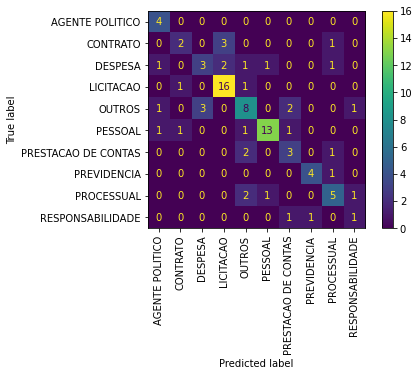

In [139]:
# Plot confusion matrix
print("Matriz de confusão:\n", \
    plot_confusion_matrix(model_comparison_df.iloc[best_estimator_test].estimator, texts, Y, xticks_rotation='vertical'))

In [140]:
print("Relatório de Classificação:\n", \
      classification_report(Y, model_comparison_df.iloc[best_estimator_test].estimator.predict(texts), digits=4))   

Relatório de Classificação:
                      precision    recall  f1-score   support

    AGENTE POLITICO     0.5714    1.0000    0.7273         4
           CONTRATO     0.5000    0.3333    0.4000         6
            DESPESA     0.5000    0.3333    0.4000         9
          LICITACAO     0.7619    0.8889    0.8205        18
             OUTROS     0.5333    0.5333    0.5333        15
            PESSOAL     0.8667    0.7647    0.8125        17
PRESTACAO DE CONTAS     0.4286    0.5000    0.4615         6
        PREVIDENCIA     0.8000    0.8000    0.8000         5
         PROCESSUAL     0.5556    0.5556    0.5556         9
   RESPONSABILIDADE     0.3333    0.3333    0.3333         3

           accuracy                         0.6413        92
          macro avg     0.5851    0.6042    0.5844        92
       weighted avg     0.6392    0.6413    0.6333        92



In [141]:
# Tests using macro average beside weighted
texts = df_test.ementa.apply(lambda x: nlp_utils.pre_processing_pipeline(x))
Y = df_test.assunto_agrupado

temp_df = \
    pd.DataFrame(columns= ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score'])
for i, row in model_comparison_df.iterrows():
    print('i: {}..., model: {}'.format(i, row.model_name))
    y_pred = row.estimator.predict(texts)
    
    temp_df = temp_df.append(score_df(row.model_name, Y, y_pred, average='macro'), ignore_index=True)

temp_df = temp_df.sort_values(by='f1_score', ascending=False)
temp_df

i: 1..., model: Random Forest
i: 4..., model: Logistic Regression
i: 0..., model: Stochastic Gradient Descent
i: 3..., model: Naive Bayes
i: 5..., model: K Nearest Neighbor
i: 2..., model: Decsision Tree


C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model_name,accuracy_score,precision_score,recall_score,f1_score
1,Logistic Regression,0.641304,0.585079,0.604248,0.584405
4,K Nearest Neighbor,0.630435,0.556859,0.562353,0.539973
0,Random Forest,0.608696,0.577511,0.517908,0.502696
3,Naive Bayes,0.586957,0.508613,0.533137,0.500702
2,Stochastic Gradient Descent,0.565217,0.443214,0.489804,0.45373
5,Decsision Tree,0.467391,0.50896,0.431373,0.444049


#### Salvar os modelos para posterior reuso

In [161]:
caminho_model = Path("../../model/")

pos = 1
for row in model_comparison_test_df.index:
    model_name = f'modelo_Prob_{pos}_{model_comparison_df.iloc[row].model_name}_.pkl'.replace(' ', '_')
    print(f'Salvando {model_name}...')
    dump(model_comparison_df.iloc[row].estimator, caminho_model/model_name)
    pos += 1

Salvando modelo_Prob_1_Logistic_Regression_.pkl...
Salvando modelo_Prob_2_K_Nearest_Neighbor_.pkl...
Salvando modelo_Prob_3_Random_Forest_.pkl...
Salvando modelo_Prob_4_Naive_Bayes_.pkl...
Salvando modelo_Prob_5_Stochastic_Gradient_Descent_.pkl...
Salvando modelo_Prob_6_Decsision_Tree_.pkl...


## Tratar problema de desbalanceamento das classes

### Analisar desempenho de modelo que mais performou

Acurácia 0.6413043478260869
F1-Score:  0.6332614396473092

Relatório de Classificação:
                      precision    recall  f1-score   support

    AGENTE POLITICO     0.5714    1.0000    0.7273         4
           CONTRATO     0.5000    0.3333    0.4000         6
            DESPESA     0.5000    0.3333    0.4000         9
          LICITACAO     0.7619    0.8889    0.8205        18
             OUTROS     0.5333    0.5333    0.5333        15
            PESSOAL     0.8667    0.7647    0.8125        17
PRESTACAO DE CONTAS     0.4286    0.5000    0.4615         6
        PREVIDENCIA     0.8000    0.8000    0.8000         5
         PROCESSUAL     0.5556    0.5556    0.5556         9
   RESPONSABILIDADE     0.3333    0.3333    0.3333         3

           accuracy                         0.6413        92
          macro avg     0.5851    0.6042    0.5844        92
       weighted avg     0.6392    0.6413    0.6333        92



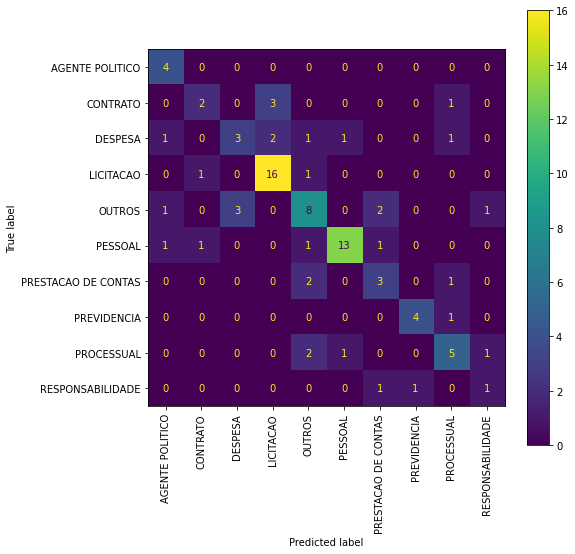

In [163]:
# Carregar modelo mais performático: Regressão Logística
loaded_model = load(caminho_model/'modelo_Prob_1_Logistic_Regression_.pkl')

texts = df_test.ementa.apply(lambda x: nlp_utils.pre_processing_pipeline(x))
Y = df_test.assunto_agrupado

print('Acurácia %s' % accuracy_score(loaded_model.predict(texts), Y))
print('F1-Score: ', f1_score(Y, loaded_model.predict(texts), average="weighted"))
print("\nRelatório de Classificação:\n", classification_report(Y, loaded_model.predict(texts), digits=4))

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(loaded_model, texts, Y, ax=ax, xticks_rotation='vertical')

É possível observar que, apesar de a acurácia ser de 64%, algumas classes apresentam recall e f1-score muito baixos.<br>
Isso justifica o experimento de técnicas para tratar o desbalanceamento das classes.

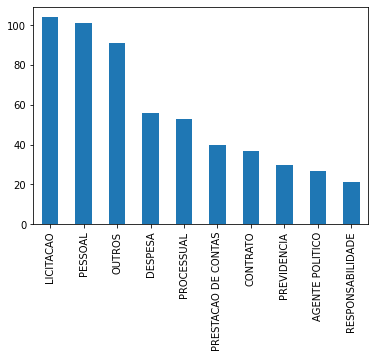

In [164]:
# Confirmar desbalanceamento da frequência
df_model.assunto_agrupado.value_counts().plot(kind='bar')

### Aplicar técnica SMOTE para tratar desbalanceamento

In [166]:
LE = LabelEncoder()
y=LE.fit_transform(df_model.assunto_agrupado)
y[:20]

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

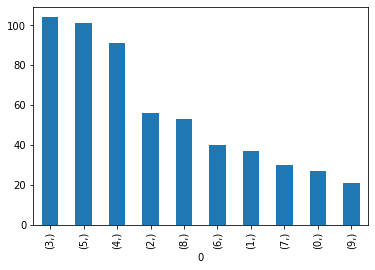

In [167]:
pd.DataFrame(y).value_counts().plot(kind='bar')

In [171]:
loaded_model.get_params()

{'memory': None,
 'steps': [('vect', TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                   stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                               'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                               'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                               'ao', 'ele', 'das', 'à', 'seu', 'sua', ...])),
  ('tfidf', TfidfTransformer()),
  ('clf', LogisticRegression(class_weight='balanced', solver='saga'))],
 'verbose': False,
 'vect': TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                 stop_words=['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em',
                             'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se',
                             'na', 'por', 'mais', 'as', 'dos', 'como', 'mas',
                             'ao', 'ele', 'das', 'à', 'seu', 'sua', ...]),
 'tfidf': TfidfTransformer(),
 'clf': LogisticRegression(class_weight='ba

In [178]:
type(loaded_model.get_params()['vect'])

sklearn.feature_extraction.text.TfidfVectorizer

In [190]:
tfidf = loaded_model.get_params()['vect']
lg = LogisticRegression(class_weight = loaded_model.get_params()['clf__class_weight']
                        ,max_iter = loaded_model.get_params()['clf__max_iter']
                        ,penalty = loaded_model.get_params()['clf__penalty']
                        ,solver = loaded_model.get_params()['clf__solver'])

X= tfidf.fit_transform(df_model.ementa_limpa)
y=LE.fit_transform(df_model.assunto_agrupado)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

oversample = SMOTE()
#X_train_s, y_train_s = oversample.fit_sample(X_train_s, y_train_s)
X_train_s, y_train_s = oversample.fit_resample(X_train_s, y_train_s)

lg.fit(X_train_s, y_train_s)
#loaded_model.fit(X_train_s, y_train_s)
pred_lg = lg.predict(X_test_s)
print('Acurácia %s' % accuracy_score(pred_lg,y_test_s))
print(classification_report(y_test_s,pred_lg))

Acurácia 0.6964285714285714
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.67      0.57      0.62         7
           2       0.38      0.45      0.42        11
           3       0.80      0.95      0.87        21
           4       0.62      0.56      0.59        18
           5       0.81      0.85      0.83        20
           6       0.80      0.50      0.62         8
           7       0.50      0.50      0.50         6
           8       0.82      0.82      0.82        11
           9       0.00      0.00      0.00         4

    accuracy                           0.70       112
   macro avg       0.61      0.62      0.61       112
weighted avg       0.67      0.70      0.68       112



C:\Users\antonio.moreira\AppData\Local\Continuum\anaconda3\envs\ocr\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


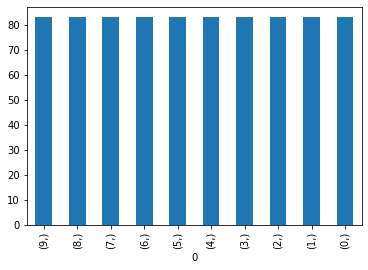

In [191]:
pd.DataFrame(y_train_s).value_counts().plot(kind='bar')

Apesar de o problema do desbalanceamento ter sido sanado, isso não resultou em melhoria de desempenho do modelo.